In [46]:
import torch
from datasets import load_dataset
import webbrowser
import os
from transformer_lens import utils, HookedTransformer
from datasets.arrow_dataset import Dataset
from sae_vis.utils_fns import get_device
from sae_vis.model_fns import AutoEncoder, AutoEncoderConfig
from sae_vis.data_storing_fns import SaeVisData
from sae_vis.data_config_classes import SaeVisConfig
import matplotlib.pyplot as plt

device = get_device()
torch.set_grad_enabled(False);

In [5]:
state_dict = torch.load("/Users/joel/Downloads/sae.pth", map_location=torch.device('cpu'))

In [17]:
new_state_dict = {
    "W_enc": state_dict["encoder.weight"].T,
    "b_enc": state_dict["encoder.bias"],
    "W_dec": state_dict["decoder.weight"].T,
    "b_dec": state_dict["decoder.bias"],
}

In [18]:
d_hidden, d_in = state_dict["encoder.weight"].shape
cfg = AutoEncoderConfig(d_in=d_in, d_hidden=d_hidden)
encoder = AutoEncoder(cfg)
encoder.load_state_dict(new_state_dict)

for k, v in encoder.named_parameters():
    print(f"{k}: {tuple(v.shape)}")

W_enc: (64, 512)
W_dec: (512, 64)
b_enc: (512,)
b_dec: (64,)


In [19]:
model = HookedTransformer.from_pretrained("roneneldan/TinyStories-1M")
model.to(device);

/Users/joel/code/sae_expected_l0/.venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Loaded pretrained model roneneldan/TinyStories-1M into HookedTransformer
Moving model to device:  mps


In [21]:
SEQ_LEN = 128

# Load in the data (it's a Dataset object)
data = load_dataset("roneneldan/TinyStories", split="train")
assert isinstance(data, Dataset)

# Tokenize the data (using a utils function) and shuffle it
tokenized_data = utils.tokenize_and_concatenate(data, model.tokenizer, max_length=SEQ_LEN) # type: ignore
tokenized_data = tokenized_data.shuffle(42)

# Get the tokens as a tensor
all_tokens = tokenized_data["tokens"]
assert isinstance(all_tokens, torch.Tensor)

print(all_tokens.shape)

torch.Size([3714797, 128])


In [23]:
device

device(type='mps')

In [35]:
model.cfg.device

'mps'

In [40]:
encoder.W_enc.device

device(type='mps', index=0)

In [39]:
encoder.to("mps")

AutoEncoder(d_in=64, dict_mult=8)

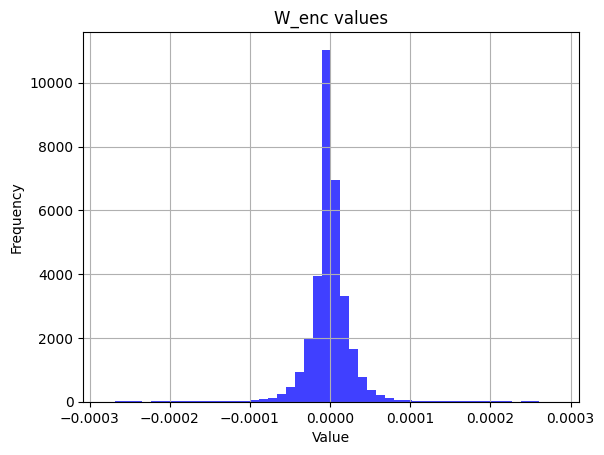

In [47]:
plt.hist(encoder.W_enc.flatten().cpu().detach().numpy(), bins=50, alpha=0.75, color='blue')
plt.title('W_enc values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

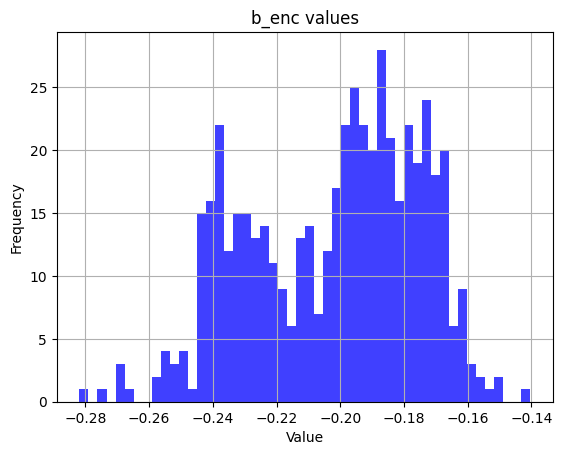

In [50]:
plt.hist(encoder.b_enc.flatten().cpu().detach().numpy(), bins=50, alpha=0.75, color='blue')
plt.title('b_enc values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

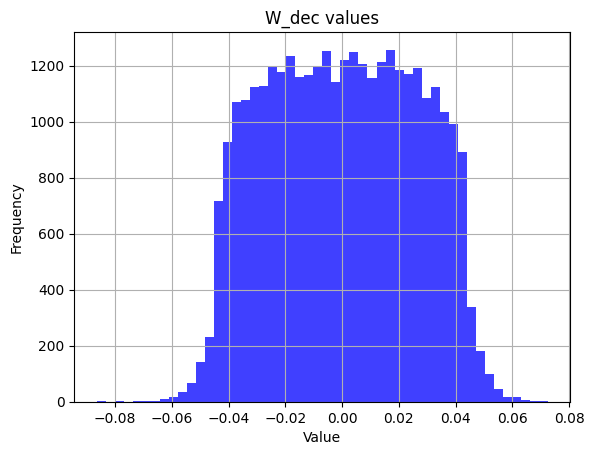

In [49]:
plt.hist(encoder.W_dec.flatten().cpu().detach().numpy(), bins=50, alpha=0.75, color='blue')
plt.title('W_dec values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

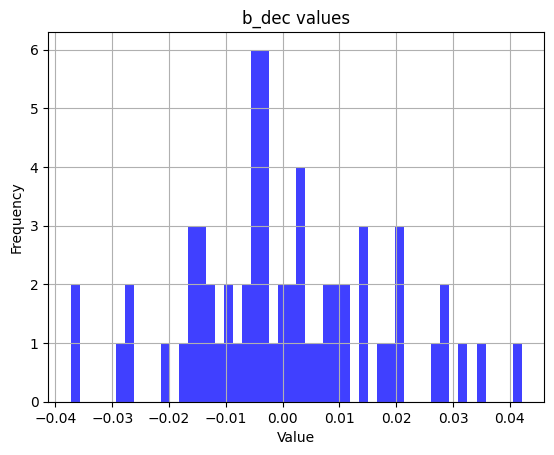

In [51]:
plt.hist(encoder.b_dec.flatten().cpu().detach().numpy(), bins=50, alpha=0.75, color='blue')
plt.title('b_dec values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
sae_vis_config = SaeVisConfig(
    hook_point = "blocks.4.hook_resid_post",
    features = range(64),
    verbose = True,
)

# Gather the feature data
sae_vis_data = SaeVisData.create(
    encoder = encoder,
    model = model,
    tokens = all_tokens[:2048],
    cfg = sae_vis_config,
)

# Save as HTML file & display vis
filename = "_feature_vis_demo.html"
sae_vis_data.save_feature_centric_vis(filename, feature_idx=8)
webbrowser.open(filename)